In this notebook we use GCN to analyze the POIs networks

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras
from keras.layers import Dense
from keras.models import Sequential
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torchtext
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv
import torch_geometric
import itertools
import nltk
import spacy
import random
from tqdm import tqdm
import time
from IPython.display import Javascript

In [4]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import math
from collections import Counter
import random
import csv
import os
import sys
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, classification_report

In [5]:
random.seed(10)

In [6]:
df = pd.read_csv('./datasets/nyc_label.csv')

In [7]:
df.tail(10)

,Unnamed: 0,Label (Grouping)_x,Own children of the householder under 6 years,Own children of the householder 6 to 17 years,Mean travel time to work (minutes),Median household income (dollars),Mean household income (dollars),Total housing units,Homeowner vacancy rate,Rental vacancy rate,...,geoid,typo,USPS,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG,label
2155,2155,"Census Tract 279, Richmond County, New York!!E...",106,301,33,"91,944","135,774",668,2.6,10.8,...,36085027900,MHI - Stable Exclusion,NY,5243636,177359,2.025,0.068,40.575221,-74.155219,0
2156,2156,"Census Tract 291.02, Richmond County, New York...",338,398,47,"89,167","97,174","1,054",0,9.5,...,36085029102,MHI - Advanced Gentrification,NY,9241350,1628913,3.568,0.629,40.611198,-74.190693,1
2157,2157,"Census Tract 291.03, Richmond County, New York...",424,"1,062",39.6,"74,732","88,155","2,760",1.8,5.2,...,36085029103,MHI - Ongoing Exclusion,NY,2030882,533,0.784,0.000,40.603550,-74.171136,0
2158,2158,"Census Tract 291.04, Richmond County, New York...",583,"1,246",43.5,"87,853","102,142","2,428",0,0,...,36085029104,MHI - Ongoing Exclusion,NY,1541565,0,0.595,0.000,40.613723,-74.163503,0
2159,2159,"Census Tract 303.01, Richmond County, New York...",247,786,48.3,"65,469","75,912","1,900",0,0,...,36085030301,MHI - Stable Exclusion,NY,719281,0,0.278,0.000,40.618920,-74.156120,0
2160,2160,"Census Tract 303.02, Richmond County, New York...",320,"1,184",47.7,"84,630","88,335","2,093",2.2,11.4,...,36085030302,MHI - Ongoing Exclusion,NY,908763,0,0.351,0.000,40.623529,-74.158743,0
2161,2161,"Census Tract 319.01, Richmond County, New York...",139,484,39.9,"23,098","32,494","1,185",3.1,7.6,...,36085031901,LI - Ongoing Gentrification,NY,388050,0,0.150,0.000,40.630303,-74.163321,1
2162,2162,"Census Tract 319.02, Richmond County, New York...",493,913,39.5,"23,289","45,694","1,856",18.6,7.7,...,36085031902,LI - At Risk of Gentrification,NY,690539,296692,0.267,0.115,40.637921,-74.165570,1
2163,2163,"Census Tract 323, Richmond County, New York!!E...",108,135,48,"64,250","76,485",526,7.3,0,...,36085032300,MHI - Stable Exclusion,NY,3869216,462391,1.494,0.179,40.636927,-74.176144,0
2164,2164,"Census Tract 9901, Richmond County, New York!!...",0,0,-,-,-,0,-,-,...,36085990100,Missing Data,NY,0,80253318,0.000,30.986,40.525549,-74.108584,0


In [8]:
df.columns

Index(['Unnamed: 0', 'Label (Grouping)_x',
       'Own children of the householder under 6 years',
       'Own children of the householder 6 to 17 years',
       'Mean travel time to work (minutes)',
       'Median household income (dollars)', 'Mean household income (dollars)',
       'Total housing units', 'Homeowner vacancy rate', 'Rental vacancy rate',
       'ROOM Median rooms', 'VALUE Median (dollars)',
       'SELECTED MONTHLY OWNER COSTS (SMOC) Housing units with a mortgage Median (dollars)',
       'SELECTED MONTHLY OWNER COSTS (SMOC) Housing units without a mortgage Median (dollars)',
       'GROSS RENT Occupied units paying rent Median (dollars)',
       'Population in households',
       'YEAR OF ENTRY Population born outside the United States',
       'YEAR OF ENTRY Foreign born', 'Total households', 'Total population',
       'Sex ratio (males per 100 females)', 'Median age (years)', 'tract_numb',
       'Label (Grouping)_y', 'Unemployment Rate',
       'Agriculture, fores

In [9]:
ids = df['GEOID']
labels = df['label ']
lats = df['INTPTLAT']
longs = df['INTPTLONG                                                                                                                             ']

In [10]:
nyc_lat_n = 40.913873
nyc_lat_s = 40.499471
nyc_long_w = -74.243356
nyc_long_e = -73.704582	

In [11]:
tracts = pd.DataFrame(list(zip(ids, lats, longs, labels)))
tracts.columns = ['id', 'lat', 'long', 'label']

In [12]:
tracts.describe()

,lat,long,label
count,2165.000000,2165.000000,2165.000000
mean,40.716169,-73.915631,0.242956
std,0.084090,0.086931,0.428968
min,40.499471,-74.243356,0.000000
25%,40.649996,-73.966678,0.000000
50%,40.706580,-73.918952,0.000000
75%,40.769097,-73.860841,0.000000
max,40.913873,-73.704582,1.000000


In [13]:
tracts.tail(10)

,id,lat,long,label
2155,14000US36085027900,40.575221,-74.155219,0
2156,14000US36085029102,40.611198,-74.190693,1
2157,14000US36085029103,40.603550,-74.171136,0
2158,14000US36085029104,40.613723,-74.163503,0
2159,14000US36085030301,40.618920,-74.156120,0
2160,14000US36085030302,40.623529,-74.158743,0
2161,14000US36085031901,40.630303,-74.163321,1
2162,14000US36085031902,40.637921,-74.165570,1
2163,14000US36085032300,40.636927,-74.176144,0
2164,14000US36085990100,40.525549,-74.108584,0


In [14]:
for index, row in tracts.iterrows():
    if (row['lat'] > nyc_lat_n or row['lat'] < nyc_lat_s or
            row['long'] > nyc_long_e or row['long'] < nyc_long_w):
        tracts = tracts.drop([index])

In [55]:
city_graph = nx.Graph()
color_map = []
for index, row in tracts.iterrows():
    city_graph.add_node((row['long'], row['lat']),
                        pos=(row['long'], row['lat']),
                        label=row['label'])
    if row['label'] == 1:
        color_map.append('steelblue')
    else:
        color_map.append('lightblue')

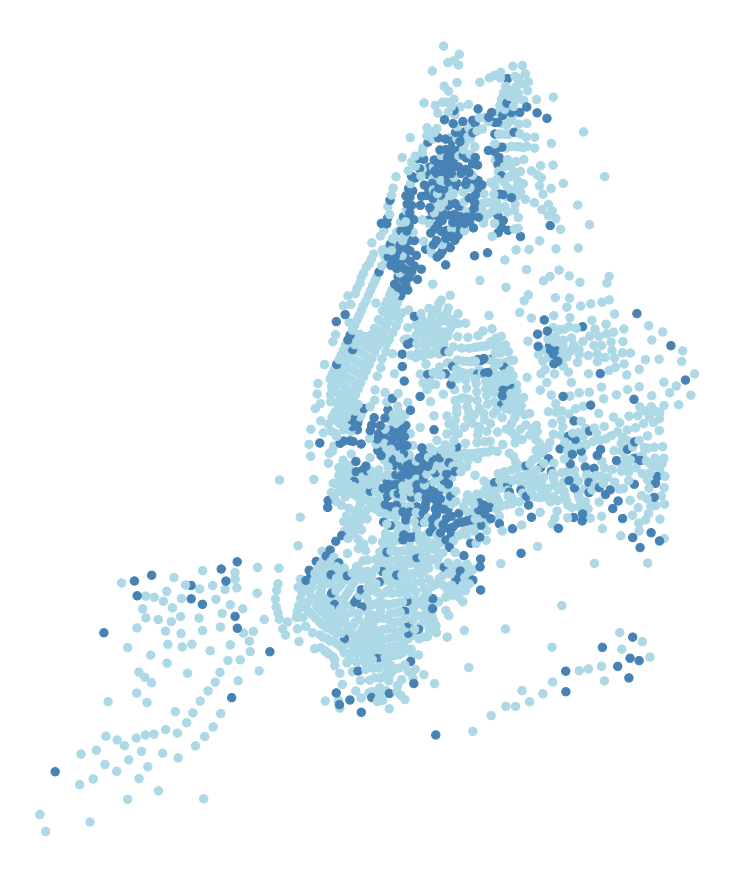

In [56]:
plt.figure(figsize=(10, 12))

pos=nx.get_node_attributes(city_graph,'pos')
nx.draw(city_graph, pos=pos,
        node_color=color_map, 
        with_labels=False,
        node_size=70)

In [57]:
def get_distance(p1, p2):
    dist = math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)
    return dist

In [58]:
hospital_locations = pd.read_csv('./datasets/nyc_hospitals.csv')['Location 1']
hospital_latlongs = [(latlong.split('\n')[2]).replace('(', '').replace(')', '').replace(' ', '').split(',') for latlong in list(hospital_locations)]

In [59]:
hospitals = []
for h in hospital_latlongs:
    longitude = float(h[1])
    latitude = float(h[0])
    if ((latitude > nyc_lat_s and latitude < nyc_lat_n) and
            (longitude > nyc_long_w and longitude < nyc_long_e)):
        hospitals.append([longitude, latitude, 0])

In [60]:
for i, hospital in enumerate(hospitals):
    closest_distance = 1000000
    for index, row in tracts.iterrows():
        dist = get_distance((row['long'], row['lat']),
                            (hospital[0], hospital[1]))
        if dist < closest_distance:
            closest_distance = dist
            label = row['label']
    hospitals[i][2] = int(label)

In [61]:
for i, values in enumerate(hospitals):
    n_long, n_lat, n_label = values
    city_graph.add_node(i,
                        pos=(n_long, n_lat))
    
    color_map.append('coral')

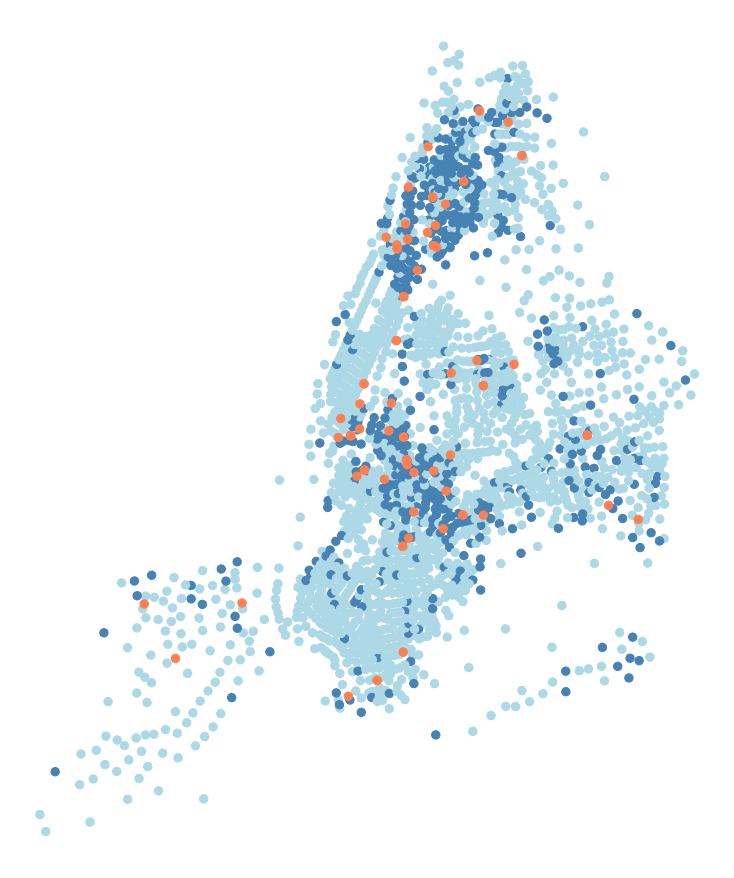

In [62]:
plt.figure(figsize=(10, 12))

pos=nx.get_node_attributes(city_graph,'pos')
nx.draw(city_graph, pos=pos,
        node_color=color_map, 
        with_labels=False,
        node_size=70)

In [63]:
subway_locations = pd.read_csv('./datasets/nyc_subway.csv')['the_geom']
subway_latlongs = [s.replace('POINT', '').replace('(', '').replace(')', '').split(' ')[1:3] for s in subway_locations]

In [64]:
subway = []
for s in subway_latlongs:
    longitude = float(s[0])
    latitude = float(s[1])
    if ((latitude > nyc_lat_s and latitude < nyc_lat_n) and
            (longitude > nyc_long_w and longitude < nyc_long_e)):
        subway.append([longitude, latitude, 0])

In [65]:
for i, s in enumerate(subway):
    closest_distance = 1000000
    for index, row in tracts.iterrows():
        dist = get_distance((row['long'], row['lat']),
                            (s[0], s[1]))
        if dist < closest_distance:
            closest_distance = dist
            label = row['label']
    subway[i][2] = int(label)

In [66]:
school_locations = pd.read_csv('./datasets/nyc_schools.csv')['Location 1']
school_latlongs = [latlong.split('\n')[1].replace('(', '').replace(')', '').replace(' ', '').split(',') for latlong in school_locations[school_locations.notnull()]]

In [67]:
schools = []
for s in school_latlongs:
    longitude = float(s[1])
    latitude = float(s[0])
    if ((latitude > nyc_lat_s and latitude < nyc_lat_n) and
            (longitude > nyc_long_w and longitude < nyc_long_e)):
        schools.append([longitude, latitude, 0])

In [68]:
for i, s in enumerate(schools):
    closest_distance = 1000000
    for index, row in tracts.iterrows():
        dist = get_distance((row['long'], row['lat']),
                            (s[0], s[1]))
        if dist < closest_distance:
            closest_distance = dist
            label = row['label']
    schools[i][2] = int(label)

In [85]:
tract_lats = tracts['lat'].tolist()
tract_longs = tracts['long'].tolist()
tract_labels = tracts['label'].tolist()

In [86]:
# Remove the components you are interested in seeing
all_nodes = list(zip(tract_longs, tract_lats, tract_labels)) + hospitals + subway + schools

In [87]:
tract_indices = list(range(0, len(tracts)))
all_indices = list(range(0, len(all_nodes)))
hospital_indices = list(range(len(tracts), len(tracts) + len(hospitals)))
subway_indices = list(range(len(tracts) + len(hospitals), len(tracts) + len(hospitals) + len(subway)))
school_indices = list(range(len(tracts) + len(hospitals) + len(subway), len(tracts) + len(hospitals) + len(subway) + len(schools)))

In [121]:
len(hospitals), len(subway), len(schools)

(78, 473, 1817)

In [89]:
# Creating a graph using NetworkX

# Adding nodes
city_graph = nx.Graph()
color_map = []
for i, values in enumerate(all_nodes):
    n_long, n_lat, n_label = values
    city_graph.add_node(i,
                        pos=(n_long, n_lat))
    
    if n_label == 1:
         color_map.append('steelblue')
    else:
        color_map.append('lightblue')

# Adding edges
# To observe only one of the networks comment out the unwanted sections
for tract_i in tract_indices+hospital_indices:
    hospital_dict = {}
    for hospital_i in hospital_indices:
        hospital_dict[hospital_i] = get_distance((all_nodes[hospital_i][0], all_nodes[hospital_i][1]),
                                             (all_nodes[tract_i][0], all_nodes[tract_i][1]))
    
    closest2 = sorted(hospital_dict, key=hospital_dict.get, reverse=False)[0:2]
    
    for i in closest2:
        s_lat = all_nodes[i][1]
        s_long = all_nodes[i][0]
        distance = get_distance((all_nodes[tract_i][0], all_nodes[tract_i][1]),
                                (s_long, s_lat))
        city_graph.add_edge(tract_i, i, weight=distance)
        # city_graph.add_edge(tract_i, i)

for tract_i in tract_indices+school_indices:
    school_dict = {}
    for school_i in school_indices:
        school_dict[school_i] = get_distance((all_nodes[school_i][0], all_nodes[school_i][1]),
                                             (all_nodes[tract_i][0], all_nodes[tract_i][1]))
    
    closest2 = sorted(school_dict, key=school_dict.get, reverse=False)[0:2]
    
    for i in closest2:
        s_lat = all_nodes[i][1]
        s_long = all_nodes[i][0]
        distance = get_distance((all_nodes[tract_i][0], all_nodes[tract_i][1]),
                                (s_long, s_lat))
        city_graph.add_edge(tract_i, i, weight=distance)
        # city_graph.add_edge(tract_i, i)

for tract_i in tract_indices+subway_indices:
    subway_dict = {}
    for subway_i in subway_indices:
        subway_dict[subway_i] = get_distance((all_nodes[subway_i][0], all_nodes[subway_i][1]),
                                             (all_nodes[tract_i][0], all_nodes[tract_i][1]))
    
    closest2 = sorted(subway_dict, key=subway_dict.get, reverse=False)[0:2]
    
    for i in closest2:
        s_lat = all_nodes[i][1]
        s_long = all_nodes[i][0]
        distance = get_distance((all_nodes[tract_i][0], all_nodes[tract_i][1]),
                                (s_long, s_lat))
        city_graph.add_edge(tract_i, i, weight=distance)
        # city_graph.add_edge(tract_i, i)

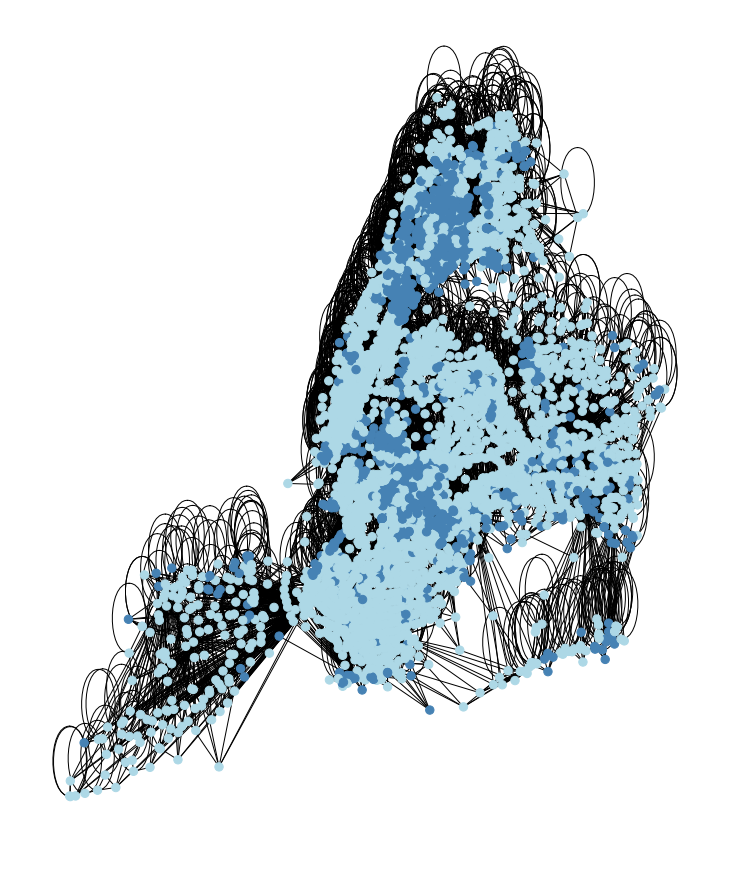

In [90]:
plt.figure(figsize=(10, 12))

pos=nx.get_node_attributes(city_graph,'pos')
nx.draw(city_graph, pos=pos,
        node_color=color_map, 
        with_labels=False,
        node_size=70)

In [91]:
tracts

,id,lat,long,label
0,14000US36005000100,40.792936,-73.881207,0
1,14000US36005000200,40.803534,-73.860661,0
2,14000US36005000400,40.808787,-73.851425,0
3,14000US36005001600,40.818848,-73.858076,1
4,14000US36005001900,40.800999,-73.909373,1
...,...,...,...,...
2160,14000US36085030302,40.623529,-74.158743,0
2161,14000US36085031901,40.630303,-74.163321,1
2162,14000US36085031902,40.637921,-74.165570,1
2163,14000US36085032300,40.636927,-74.176144,0


In [92]:
hospitals_graph = nx.Graph()
nodes = list(zip(tract_longs, tract_lats, tract_labels))+hospitals

for i, values in enumerate(nodes):
    n_long, n_lat, n_label = values
    hospitals_graph.add_node(i, pos=(n_long, n_lat))

# Adding edges
for tract_i,_ in enumerate(nodes):
    hospital_dict = {}
    for hospital_i,_ in enumerate(hospitals):
        hospital_i += len(tract_labels)
        hospital_dict[hospital_i] = get_distance((nodes[hospital_i][0], nodes[hospital_i][1]),
                                             (nodes[tract_i][0], nodes[tract_i][1]))
    
    closest2 = sorted(hospital_dict, key=hospital_dict.get, reverse=False)[0:2]
    
    for i in closest2:
        s_lat = nodes[i][1]
        s_long = nodes[i][0]
        distance = get_distance((nodes[tract_i][0], nodes[tract_i][1]),
                                (s_long, s_lat))
        hospitals_graph.add_edge(tract_i, i, weight=distance)


In [93]:
subway_graph = nx.Graph()
nodes = list(zip(tract_longs, tract_lats, tract_labels))+subway

for i, values in enumerate(nodes):
    n_long, n_lat, n_label = values
    subway_graph.add_node(i, pos=(n_long, n_lat))

# Adding edges
for tract_i,_ in enumerate(nodes):
    subway_dict = {}
    for subway_i,_ in enumerate(subway):
        subway_i += len(tract_labels)
        subway_dict[subway_i] = get_distance((nodes[subway_i][0], nodes[subway_i][1]),
                                             (nodes[tract_i][0], nodes[tract_i][1]))
    
    closest2 = sorted(subway_dict, key=subway_dict.get, reverse=False)[0:2]
    
    for i in closest2:
        s_lat = nodes[i][1]
        s_long = nodes[i][0]
        distance = get_distance((nodes[tract_i][0], nodes[tract_i][1]),
                                (s_long, s_lat))
        subway_graph.add_edge(tract_i, i, weight=distance)


In [94]:
schools_graph = nx.Graph()
nodes = list(zip(tract_longs, tract_lats, tract_labels))+schools

for i, values in enumerate(nodes):
    n_long, n_lat, n_label = values
    schools_graph.add_node(i, pos=(n_long, n_lat))

# Adding edges
for tract_i,_ in enumerate(nodes):
    schools_dict = {}
    for school_i,_ in enumerate(schools):
        school_i += len(tract_labels)
        schools_dict[school_i] = get_distance((nodes[school_i][0], nodes[school_i][1]),
                                             (nodes[tract_i][0], nodes[tract_i][1]))
    
    closest2 = sorted(schools_dict, key=schools_dict.get, reverse=False)[0:2]
    
    for i in closest2:
        s_lat = nodes[i][1]
        s_long = nodes[i][0]
        distance = get_distance((nodes[tract_i][0], nodes[tract_i][1]),
                                (s_long, s_lat))
        schools_graph.add_edge(tract_i, i, weight=distance)


In [95]:
def from_networkx(G, labels):
    G = nx.convert_node_labels_to_integers(G)
    edge_index = torch.LongTensor(list(G.edges)).t().contiguous()
    data = {}
    for i, (_, feat_dict) in enumerate(G.nodes(data=True)):
        for key, value in feat_dict.items():
            data[str(key)] = [value] if i == 0 else data[str(key)] + [value]

    for i, (_, _, feat_dict) in enumerate(G.edges(data=True)):
        for key, value in feat_dict.items():
            data[str(key)] = [value] if i == 0 else data[str(key)] + [value]

    for key, item in data.items():
        try:
            data[key] = torch.tensor(item)
        except ValueError:
            pass
    data['edge_index'] = edge_index.view(2, -1)
    data = torch_geometric.data.Data.from_dict(data)
    data.num_nodes = G.number_of_nodes()
    data.x=torch.from_numpy(np.eye(data.num_nodes))

    all_indices = list(range(0, data.num_nodes))
    random.shuffle(all_indices)
    train_indices = all_indices[0:int(data.num_nodes*0.8)]
    test_indices = all_indices[int(data.num_nodes*0.8):data.num_nodes]

    train_mask = np.array([False]*data.num_nodes)
    train_mask[train_indices] = True
    data.train_mask = torch.from_numpy(train_mask)

    test_mask = np.array([False]*data.num_nodes)
    test_mask[test_indices] = True
    data.test_mask=torch.from_numpy(test_mask)
    
    data.y = torch.from_numpy(labels)
    
    return data

labels = [label for _,_,label in all_nodes]
y = np.asarray(labels)

data = from_networkx(city_graph, y)

In [96]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        # super(GCN, self).__init__()
        # torch.manual_seed(12345)
        # self.conv1 = GCNConv(data.num_features, hidden_channels)
        # self.conv2 = GCNConv(hidden_channels, 2)

        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(data.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, 4)

    def forward(self, x, edge_index):
        # x = self.conv1(x, edge_index)
        # x = x.relu()
        # x = F.dropout(x, p=0.5, training=self.training)
        # x = self.conv2(x, edge_index)
        
        x = self.conv1(x, edge_index)
        x = x.tanh()
        x = self.conv2(x, edge_index)
        x = x.tanh()
        x = self.conv3(x, edge_index)
        x = x.tanh()  # Final GNN embedding space.
        out = self.classifier(x)

        return x

model = GCN(hidden_channels=16)
model.eval()
print(model)

GCN(
  (conv1): GCNConv(4532, 16)
  (conv2): GCNConv(16, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


In [97]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train(dataset):
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(dataset.x.to(torch.float), dataset.edge_index)  # Perform a single forward pass.
      loss = criterion(out[dataset.train_mask], dataset.y[dataset.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(dataset):
      model.eval()
      out = model(dataset.x.to(torch.float), dataset.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[dataset.test_mask] == dataset.y[dataset.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(dataset.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

loss_lst = []
for epoch in range(1, 300):
    loss = train(data)
    loss_lst.append(float(loss))
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 0.6938
Epoch: 002, Loss: 0.6326
Epoch: 003, Loss: 0.5860
Epoch: 004, Loss: 0.5512
Epoch: 005, Loss: 0.5241
Epoch: 006, Loss: 0.4999
Epoch: 007, Loss: 0.4748
Epoch: 008, Loss: 0.4475
Epoch: 009, Loss: 0.4188
Epoch: 010, Loss: 0.3917
Epoch: 011, Loss: 0.3683
Epoch: 012, Loss: 0.3495
Epoch: 013, Loss: 0.3346
Epoch: 014, Loss: 0.3225
Epoch: 015, Loss: 0.3121
Epoch: 016, Loss: 0.3024
Epoch: 017, Loss: 0.2928
Epoch: 018, Loss: 0.2835
Epoch: 019, Loss: 0.2749
Epoch: 020, Loss: 0.2675
Epoch: 021, Loss: 0.2615
Epoch: 022, Loss: 0.2569
Epoch: 023, Loss: 0.2531
Epoch: 024, Loss: 0.2495
Epoch: 025, Loss: 0.2457
Epoch: 026, Loss: 0.2418
Epoch: 027, Loss: 0.2382
Epoch: 028, Loss: 0.2352
Epoch: 029, Loss: 0.2329
Epoch: 030, Loss: 0.2308
Epoch: 031, Loss: 0.2287
Epoch: 032, Loss: 0.2267
Epoch: 033, Loss: 0.2248
Epoch: 034, Loss: 0.2231
Epoch: 035, Loss: 0.2216
Epoch: 036, Loss: 0.2199
Epoch: 037, Loss: 0.2182
Epoch: 038, Loss: 0.2166
Epoch: 039, Loss: 0.2151
Epoch: 040, Loss: 0.2137


In [98]:
out = model(data.x.to(torch.float), data.edge_index)

In [99]:
pred_vals = out.argmax(dim=1)[data.test_mask].tolist()
true_vals = data.y[data.test_mask]

In [100]:
test_acc = test(data)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8379


In [101]:
roc_auc_score(true_vals, pred_vals)

0.8221703925365252

In [102]:
confusion_matrix(true_vals, pred_vals)

array([[528,  80],
       [ 67, 232]])

In [103]:
sum(true_vals)/len(true_vals)

tensor(0.3297)

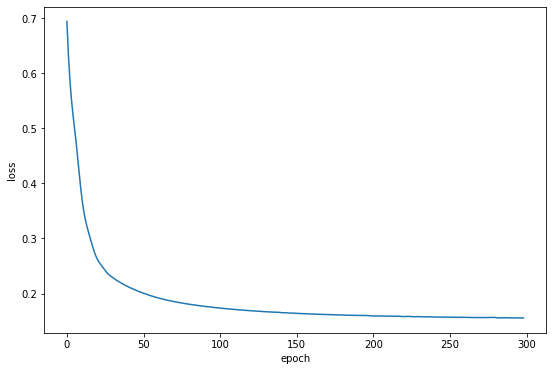

In [104]:
plt.figure(figsize=(9,6))
plt.plot(range(0, len(loss_lst)), loss_lst)
plt.xlabel("epoch")
plt.ylabel("loss");

In [105]:
all_preds_lst = []
all_true_lst = []

for iteration in range(0, 10):
    data = from_networkx(hospitals_graph, y[tract_indices+hospital_indices])
    model = GCN(hidden_channels=16)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(1, 200):
        loss = train(data)
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    
    out = model(data.x.to(torch.float), data.edge_index)
    pred_vals = out.argmax(dim=1)[data.test_mask].tolist()
    true_vals = data.y[data.test_mask].tolist()

    all_preds_lst.extend(pred_vals)
    all_true_lst.extend(true_vals)

    print(len(pred_vals), len(all_preds_lst))


Epoch: 001, Loss: 0.6931
Epoch: 002, Loss: 0.6509
Epoch: 003, Loss: 0.6117
Epoch: 004, Loss: 0.5741
Epoch: 005, Loss: 0.5393
Epoch: 006, Loss: 0.5085
Epoch: 007, Loss: 0.4819
Epoch: 008, Loss: 0.4588
Epoch: 009, Loss: 0.4375
Epoch: 010, Loss: 0.4165
Epoch: 011, Loss: 0.3945
Epoch: 012, Loss: 0.3709
Epoch: 013, Loss: 0.3464
Epoch: 014, Loss: 0.3221
Epoch: 015, Loss: 0.2999
Epoch: 016, Loss: 0.2812
Epoch: 017, Loss: 0.2663
Epoch: 018, Loss: 0.2548
Epoch: 019, Loss: 0.2458
Epoch: 020, Loss: 0.2382
Epoch: 021, Loss: 0.2315
Epoch: 022, Loss: 0.2253
Epoch: 023, Loss: 0.2194
Epoch: 024, Loss: 0.2137
Epoch: 025, Loss: 0.2085
Epoch: 026, Loss: 0.2038
Epoch: 027, Loss: 0.1996
Epoch: 028, Loss: 0.1960
Epoch: 029, Loss: 0.1931
Epoch: 030, Loss: 0.1909
Epoch: 031, Loss: 0.1893
Epoch: 032, Loss: 0.1882
Epoch: 033, Loss: 0.1874
Epoch: 034, Loss: 0.1866
Epoch: 035, Loss: 0.1858
Epoch: 036, Loss: 0.1850
Epoch: 037, Loss: 0.1842
Epoch: 038, Loss: 0.1834
Epoch: 039, Loss: 0.1827
Epoch: 040, Loss: 0.1820


In [106]:
print(classification_report(all_true_lst, all_preds_lst))

              precision    recall  f1-score   support

           0       0.77      0.93      0.85      3355
           1       0.49      0.20      0.28      1135

    accuracy                           0.75      4490
   macro avg       0.63      0.56      0.56      4490
weighted avg       0.70      0.75      0.70      4490



In [107]:
roc_auc_score(all_true_lst, all_preds_lst)

0.563662624657786

In [108]:
preds_df = pd.DataFrame([all_true_lst, all_preds_lst]).T
preds_df.columns = ['true', 'prediction']
preds_df.to_csv("./datasets/nyc_hospitals_predictions.csv", encoding='utf-8', index=False)

In [109]:
all_preds_lst = []
all_true_lst = []

for iteration in range(0, 10):
    data = from_networkx(subway_graph, y[tract_indices+subway_indices])
    model = GCN(hidden_channels=16)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(1, 200):
        loss = train(data)
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    
    out = model(data.x.to(torch.float), data.edge_index)
    pred_vals = out.argmax(dim=1)[data.test_mask].tolist()
    true_vals = data.y[data.test_mask].tolist()

    all_preds_lst.extend(pred_vals)
    all_true_lst.extend(true_vals)

    print(len(pred_vals), len(all_preds_lst))

Epoch: 001, Loss: 0.6940
Epoch: 002, Loss: 0.6355
Epoch: 003, Loss: 0.5867
Epoch: 004, Loss: 0.5467
Epoch: 005, Loss: 0.5142
Epoch: 006, Loss: 0.4875
Epoch: 007, Loss: 0.4641
Epoch: 008, Loss: 0.4419
Epoch: 009, Loss: 0.4190
Epoch: 010, Loss: 0.3948
Epoch: 011, Loss: 0.3701
Epoch: 012, Loss: 0.3463
Epoch: 013, Loss: 0.3249
Epoch: 014, Loss: 0.3067
Epoch: 015, Loss: 0.2917
Epoch: 016, Loss: 0.2794
Epoch: 017, Loss: 0.2690
Epoch: 018, Loss: 0.2600
Epoch: 019, Loss: 0.2520
Epoch: 020, Loss: 0.2446
Epoch: 021, Loss: 0.2375
Epoch: 022, Loss: 0.2309
Epoch: 023, Loss: 0.2248
Epoch: 024, Loss: 0.2194
Epoch: 025, Loss: 0.2149
Epoch: 026, Loss: 0.2113
Epoch: 027, Loss: 0.2084
Epoch: 028, Loss: 0.2060
Epoch: 029, Loss: 0.2036
Epoch: 030, Loss: 0.2013
Epoch: 031, Loss: 0.1990
Epoch: 032, Loss: 0.1968
Epoch: 033, Loss: 0.1949
Epoch: 034, Loss: 0.1933
Epoch: 035, Loss: 0.1919
Epoch: 036, Loss: 0.1906
Epoch: 037, Loss: 0.1894
Epoch: 038, Loss: 0.1882
Epoch: 039, Loss: 0.1871
Epoch: 040, Loss: 0.1860


In [110]:
print(classification_report(all_true_lst, all_preds_lst))

              precision    recall  f1-score   support

           0       0.80      0.90      0.84      3928
           1       0.53      0.34      0.41      1352

    accuracy                           0.75      5280
   macro avg       0.66      0.62      0.63      5280
weighted avg       0.73      0.75      0.73      5280



In [111]:
roc_auc_score(all_true_lst, all_preds_lst)

0.6160798214005955

In [112]:
preds_df = pd.DataFrame([all_true_lst, all_preds_lst]).T
preds_df.columns = ['true', 'prediction']
preds_df.to_csv("./datasets/nyc_subway_predictions.csv", encoding='utf-8', index=False)

In [113]:
all_preds_lst = []
all_true_lst = []

for iteration in range(0, 10):
    data = from_networkx(schools_graph, y[tract_indices+school_indices])
    model = GCN(hidden_channels=16)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(1, 200):
        loss = train(data)
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    
    out = model(data.x.to(torch.float), data.edge_index)
    pred_vals = out.argmax(dim=1)[data.test_mask].tolist()
    true_vals = data.y[data.test_mask].tolist()

    all_preds_lst.extend(pred_vals)
    all_true_lst.extend(true_vals)

    print(len(pred_vals), len(all_preds_lst))


Epoch: 001, Loss: 0.6937
Epoch: 002, Loss: 0.6346
Epoch: 003, Loss: 0.5832
Epoch: 004, Loss: 0.5410
Epoch: 005, Loss: 0.5075
Epoch: 006, Loss: 0.4790
Epoch: 007, Loss: 0.4510
Epoch: 008, Loss: 0.4203
Epoch: 009, Loss: 0.3867
Epoch: 010, Loss: 0.3524
Epoch: 011, Loss: 0.3209
Epoch: 012, Loss: 0.2948
Epoch: 013, Loss: 0.2751
Epoch: 014, Loss: 0.2606
Epoch: 015, Loss: 0.2493
Epoch: 016, Loss: 0.2394
Epoch: 017, Loss: 0.2298
Epoch: 018, Loss: 0.2201
Epoch: 019, Loss: 0.2110
Epoch: 020, Loss: 0.2033
Epoch: 021, Loss: 0.1974
Epoch: 022, Loss: 0.1933
Epoch: 023, Loss: 0.1904
Epoch: 024, Loss: 0.1882
Epoch: 025, Loss: 0.1859
Epoch: 026, Loss: 0.1834
Epoch: 027, Loss: 0.1809
Epoch: 028, Loss: 0.1789
Epoch: 029, Loss: 0.1774
Epoch: 030, Loss: 0.1764
Epoch: 031, Loss: 0.1756
Epoch: 032, Loss: 0.1749
Epoch: 033, Loss: 0.1741
Epoch: 034, Loss: 0.1733
Epoch: 035, Loss: 0.1725
Epoch: 036, Loss: 0.1718
Epoch: 037, Loss: 0.1712
Epoch: 038, Loss: 0.1705
Epoch: 039, Loss: 0.1699
Epoch: 040, Loss: 0.1693


In [114]:
print(classification_report(all_true_lst, all_preds_lst))

              precision    recall  f1-score   support

           0       0.90      0.91      0.90      5596
           1       0.78      0.76      0.77      2374

    accuracy                           0.86      7970
   macro avg       0.84      0.83      0.84      7970
weighted avg       0.86      0.86      0.86      7970



In [115]:
roc_auc_score(all_true_lst, all_preds_lst)

0.8334812957624684

In [116]:
preds_df = pd.DataFrame([all_true_lst, all_preds_lst]).T
preds_df.columns = ['true', 'prediction']
preds_df.to_csv("./datasets/nyc_schools_predictions.csv", encoding='utf-8', index=False)

In [117]:
all_preds_lst = []
all_true_lst = []

for iteration in range(0, 10):
    data = from_networkx(city_graph, y)
    model = GCN(hidden_channels=16)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(1, 200):
        loss = train(data)
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    
    out = model(data.x.to(torch.float), data.edge_index)
    pred_vals = out.argmax(dim=1)[data.test_mask].tolist()
    true_vals = data.y[data.test_mask].tolist()

    all_preds_lst.extend(pred_vals)
    all_true_lst.extend(true_vals)

    print(len(pred_vals), len(all_preds_lst))


Epoch: 001, Loss: 0.6936
Epoch: 002, Loss: 0.6326
Epoch: 003, Loss: 0.5860
Epoch: 004, Loss: 0.5513
Epoch: 005, Loss: 0.5241
Epoch: 006, Loss: 0.4997
Epoch: 007, Loss: 0.4742
Epoch: 008, Loss: 0.4464
Epoch: 009, Loss: 0.4176
Epoch: 010, Loss: 0.3905
Epoch: 011, Loss: 0.3676
Epoch: 012, Loss: 0.3496
Epoch: 013, Loss: 0.3355
Epoch: 014, Loss: 0.3239
Epoch: 015, Loss: 0.3135
Epoch: 016, Loss: 0.3037
Epoch: 017, Loss: 0.2940
Epoch: 018, Loss: 0.2848
Epoch: 019, Loss: 0.2763
Epoch: 020, Loss: 0.2691
Epoch: 021, Loss: 0.2632
Epoch: 022, Loss: 0.2586
Epoch: 023, Loss: 0.2546
Epoch: 024, Loss: 0.2509
Epoch: 025, Loss: 0.2471
Epoch: 026, Loss: 0.2432
Epoch: 027, Loss: 0.2397
Epoch: 028, Loss: 0.2368
Epoch: 029, Loss: 0.2344
Epoch: 030, Loss: 0.2324
Epoch: 031, Loss: 0.2303
Epoch: 032, Loss: 0.2282
Epoch: 033, Loss: 0.2263
Epoch: 034, Loss: 0.2247
Epoch: 035, Loss: 0.2233
Epoch: 036, Loss: 0.2217
Epoch: 037, Loss: 0.2200
Epoch: 038, Loss: 0.2183
Epoch: 039, Loss: 0.2167
Epoch: 040, Loss: 0.2154


In [118]:
print(classification_report(all_true_lst, all_preds_lst))

              precision    recall  f1-score   support

           0       0.89      0.88      0.88      6244
           1       0.73      0.75      0.74      2826

    accuracy                           0.84      9070
   macro avg       0.81      0.81      0.81      9070
weighted avg       0.84      0.84      0.84      9070



In [119]:
roc_auc_score(all_true_lst, all_preds_lst)

0.8140569086450381

In [120]:
preds_df = pd.DataFrame([all_true_lst, all_preds_lst]).T
preds_df.columns = ['true', 'prediction']
preds_df.to_csv("./datasets/nyc_everything_predictions.csv", encoding='utf-8', index=False)